In [1]:
import autograd.numpy as np
from autograd import grad
import scipy as sc
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt

%matplotlib inline

import seaborn as sns
import math
from scipy import optimize


In [4]:
oc1 = sio.loadmat('occam1.mat')
oc2 = sio.loadmat('occam2.mat')
D1=np.array([oc1['x'].T[0],oc1['y'].T[0]])
D2=np.array([oc2['x'].T[0],oc2['y'].T[0]])

In [5]:
#construct design matrices
def phi_1(x, z=None):
    return(np.array([x**0,x,x**2,x**3,x**4,x**5]).T)
def phi_2(x, z):
    return(np.array([np.exp(-(x-1)**2/z[0]**2), np.exp(-(x-5)**2/z[1]**2)]).T)
def phi_3(x, z=None):
    return(np.array([x,np.cos(2*x)]).T)

phi11 = phi_1(D1[0])
phi12 = phi_2(D1[0],z=[1,1])
phi13 = phi_3(D1[0])
phi21 = phi_1(D2[0])
phi22 = phi_2(D2[0],z=[1,1])
phi23 = phi_3(D2[0])
x1 = D1[0]
x2 = D2[0]
y1 = D1[1]
y2 = D2[1]
z = [1.0,1.0]

In [6]:
def gradphi(phi,x,z):
    dphidz1 = np.array([np.multiply((2*(x-1)**2)/(z[0]**3), phi[:,0]), np.zeros(len(x))]).T
    dphidz2 = np.array([np.zeros(len(x)), np.multiply((2*(x-5)**2)/(z[1]**3), phi[:,1])]).T
    return(np.array([dphidz1,dphidz2]))

class model():
    def __init__(self, x, y, phifunc, z=None):
        self.x = x
        self.y = y
        self.phifunc = phifunc
        self.z = z 
    
    def fastgrad(self, params):
        loga2 = params[0]
        logsig2 = params[1]
        a2 = np.exp(loga2)
        sig2 = np.exp(logsig2)
        if(self.z!=None):
            self.z = [params[2], params[3]]
        phi = self.phifunc(self.x, self.z)
        y = self.y
        x = self.x
        n = len(self.y)
        p = phi.shape[1]
        sigmap = a2/sig2 * np.dot(phi.T, phi)+np.identity(p)
        invsp = np.linalg.inv(sigmap)
        #gradient for a2
        tracea = 1/sig2*np.trace(np.dot(phi.T, phi))-\
            a2/sig2**2*np.trace(np.dot(phi.T, np.dot(phi, np.dot(invsp, np.dot(phi.T, phi)))))
        ysppsy = 1/sig2**2*np.dot(y.T, np.dot(phi, np.dot(phi.T, y)))-\
            2*a2/(sig2**3)*np.dot(y.T, np.dot(phi, np.dot(phi.T, np.dot(phi, np.dot(invsp, np.dot(phi.T, y))))))+\
            a2**2/(sig2**4)*np.dot(y.T, np.dot(phi, np.dot(invsp, np.dot(phi.T, np.dot(phi, np.dot(phi.T, np.dot(phi, np.dot(invsp, np.dot(phi.T, y)))))))))
        dlda2 = -1/2*(ysppsy-tracea)*a2
        #gradient for sigma2
        traces = 1/sig2*np.trace(np.identity(n))-a2/sig2**2*np.trace(np.dot(phi.T,np.dot(phi, invsp)))
        yssy = 1/sig2**2*np.dot(y.T, y)-2*a2/(sig2**3)*np.dot(y.T, np.dot(phi, np.dot(invsp, np.dot(phi.T, y))))+\
             a2**2/(sig2**4)*np.dot(y.T, np.dot(phi, np.dot(invsp, np.dot(phi.T, np.dot(phi, np.dot(invsp, np.dot(phi.T, y)))))))
        dlds2 = -1/2*(yssy-traces)*sig2
        gradients = [dlda2, dlds2]
        #gradient for z
        dldz = np.zeros(len(z))
        if(self.z!=None):
            dldz = np.zeros(len(self.z))
            dphidz = gradphi(phi, x, z)
            for i in range(len(self.z)):
                trace = 1/sig2*np.trace(np.dot(phi.T, dphidz[i]))-\
                    a2/sig2**2*np.trace(np.dot(phi.T, np.dot(phi, np.dot(invsp, np.dot(phi.T, dphidz[0])))))
                trace *=2
                yspppsy = 1/sig2**2*np.dot(y.T, np.dot(dphidz[i], np.dot(phi.T, y)))-\
                     a2/sig2**3*np.dot(y.T, np.dot(dphidz[i], np.dot(phi.T, np.dot(phi, np.dot(invsp, np.dot(phi.T, y))))))-\
                     a2/sig2**3*np.dot(y.T, np.dot(phi, np.dot(invsp, np.dot(phi.T, np.dot(dphidz[i], np.dot(phi.T, y))))))+\
                     a2**2/sig2**4*np.dot(y.T, np.dot(phi, np.dot(invsp, np.dot(phi.T, np.dot(dphidz[i], np.dot(phi.T, np.dot(phi, np.dot(invsp, np.dot(phi.T, y)))))))))
                yspppsy *= 2
                dldz[i] = a2/2*(yspppsy-trace)
                gradients.append(dldz[i])
        return np.array(gradients)
    
    def fastlogmarg(self, params):
        loga2 = params[0]
        logsig2 = params[1]
        a2 = np.exp(loga2)
        sig2 = np.exp(logsig2)
        y = self.y
        if(self.z!=None):
            self.z = [params[2], params[3]]
        phi = self.phifunc(self.x, self.z)
        n = len(self.y)
        p = phi.shape[1]
        sigmap = a2/sig2*np.dot(phi.T, phi)+np.identity(p)
        detsp = np.linalg.det(sigmap)
        invsp = np.linalg.inv(sigmap)
        exponent = 1/(2*sig2)*np.dot(y.T, y)-a2/(2*sig2**2)*np.dot(y.T, np.dot(phi, np.dot(invsp, np.dot(phi.T, y))))
        logmarg = -n/2*np.log(2*math.pi)-n/2*np.log(sig2)-1/2*np.log(detsp)-exponent
        return(-logmarg)
    

In [35]:
tes = model(x1, y1, phi_2, [1.0, 1.0])
print(tes.fastlogmarg([np.log(4), np.log(4), 1.0, 1.0]))
print(tes.fastgrad([np.log(4), np.log(4), 1.0, 1.0]))

4500.85844857
[ -2.52645086e+02  -4.21587130e+03  -3.24823358e+00   1.94750620e+02]


[-51.98325562   7.88311054] [-32.52751328   7.88311057] [-9.14829846  7.88311157]


<BarContainer object of 3 artists>

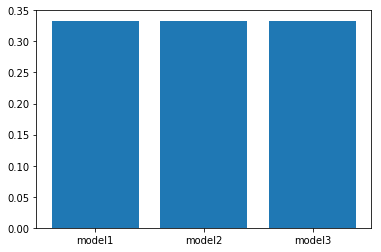

In [7]:
model1 = model(x1, y1, phi_1)
model2 = model(x1, y1, phi_2, [1.0, 1.0])
model3 = model(x1, y1, phi_3)
loghyperparameters = [0.5,1.0]
hyperparameters2 = [1.0, 1.0, 1.0, 1.0]
model1opt = optimize.minimize(model1.fastlogmarg, x0=loghyperparameters, method="BFGS", jac=model1.fastgrad, options={'maxiter':400})
model2opt = optimize.minimize(model2.fastlogmarg, x0=hyperparameters2, method="BFGS", jac=model2.fastgrad, options={'maxiter':400})
model3opt = optimize.minimize(model3.fastlogmarg, x0=loghyperparameters, method="BFGS", jac=model3.fastgrad, options={'maxiter':400})

logmargres = [model1opt.fun, model2opt.fun, model3opt.fun]
print(model1opt.x, model2opt.x[0:2], model3opt.x)
x = ["model1", "model2", "model3"]
plt.bar(x, logmargres/np.sum(logmargres))

In [39]:
print(np.exp(model1opt.x))
print(np.exp(model2opt.x))
print(np.exp(model1opt.x))

[  2.65435455e-23   2.65210924e+03]
[  7.47275035e-15   2.65210932e+03   1.98445483e-08   1.61398110e+21]
[  2.65435455e-23   2.65210924e+03]


<BarContainer object of 3 artists>

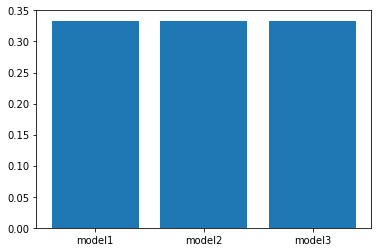

In [8]:
model1b = model(x2, y2, phi_1)
model2b = model(x2, y2, phi_2, [1.0, 1.0])
model3b = model(x2, y2, phi_3)

model1bopt = optimize.minimize(model1b.fastlogmarg, x0=loghyperparameters, method="Nelder-Mead")
model2bopt = optimize.minimize(model2b.fastlogmarg, x0=hyperparameters2, method="Nelder-Mead")
model3bopt = optimize.minimize(model3b.fastlogmarg, x0=loghyperparameters, method="Nelder-Mead")

logmargres2 = [model1bopt.fun, model2bopt.fun, model3bopt.fun]
plt.bar(x, logmargres2/np.sum(logmargres2))

In [38]:
print(np.exp(model1bopt.x))
print(np.exp(model2bopt.x))
print(np.exp(model1bopt.x))


[   22.58504929  2515.23002219]
[  1.36469243e+01   2.51744798e+03   3.52043834e-01              inf]
[   22.58504929  2515.23002219]


/anaconda3/lib/python3.6/site-packages/autograd/core.py:163: RuntimeWarning: overflow encountered in exp
  result = self.fun(*argvals, **kwargs)


Calculating posterior mean of the weights for D2

In [24]:
a2h, sig2h = np.exp(model1bopt.x)
p1 = 6
invpostcov = 1/a2h*np.identity(p1)+1/sig2h*np.dot(phi21.T, phi21)
postcov = np.linalg.inv(invpostcov)
postvar = np.diagonal(postcov)
postmean = (1/sig2h)*np.dot(postcov, np.dot(phi21.T, y2))
print("posterior mean:", postmean)
print("posterior variance:", postvar)

posterior mean: [  4.26865845e+00  -9.08897524e+00   5.32988237e+00  -1.16468722e+00
   1.06161091e-01  -3.33802248e-03]
posterior variance: [  7.59268406e-01   2.93219334e+00   1.14110083e+00   7.49884499e-02
   9.30397461e-04   1.50032894e-06]


In [30]:
a2h, sig2h = np.exp(model2bopt.x[0:2])
p2 = 2
phi22 = phi_2(x2, model2bopt.x[2:4])
invpostcov = 1/a2h*np.identity(p2)+1/sig2h*np.dot(phi22.T, phi22)
postcov = np.linalg.inv(invpostcov)
postvar = np.diagonal(postcov)
postmean = (1/sig2h)*np.dot(postcov, np.dot(phi22.T, y2))
print("posterior mean:", postmean)
print("posterior variance:", postvar)

posterior mean: [-4.41511651  2.7436875 ]
posterior variance: [ 0.24782484  0.032301  ]


In [31]:
a2h, sig2h = np.exp(model1bopt.x)
p3 = 2
invpostcov = 1/a2h*np.identity(p3)+1/sig2h*np.dot(phi23.T, phi23)
postcov = np.linalg.inv(invpostcov)
postvar = np.diagonal(postcov)
postmean = (1/sig2h)*np.dot(postcov, np.dot(phi23.T, y2))
print("posterior mean:", postmean)
print("posterior variance:", postvar)

posterior mean: [ 0.35261133  4.86124578]
posterior variance: [ 0.0007664  0.0498949]
